Import necessary packages and set up defauls for figure formatting:

In [1]:
import glob #filenames and pathnames utility
import os   #operating sytem utility
import string

import warnings

import matplotlib.pyplot as plt

import numpy as np
import pandas as pd

import statsmodels.api as sm
import statsmodels.formula.api as smf

import pickle

import seaborn as sns
sns.set()

%load_ext autoreload
%autoreload 2

%matplotlib inline

%autosave 0

# set global default style:
sns.set_style("white")
sns.set_style("ticks", {'xtick.direction':'in', 'xtick.top':True, 'ytick.direction':'in', 'ytick.right':True, })
#sns.set_style({"axes.labelsize": 20, "xtick.labelsize" : 16, "ytick.labelsize" : 16})

plt.rcParams['axes.labelsize'] = 20
plt.rcParams['xtick.labelsize'] = 16
plt.rcParams['ytick.labelsize'] = 16

plt.rcParams['legend.fontsize'] = 14
plt.rcParams['legend.edgecolor'] = 'k'

box_size = 8

Autosave disabled


In [2]:
main_dir = os.getcwd()
main_dir

'C:\\Users\\djross\\Documents\\Python Scripts\\culture_reproducibility'

In [3]:
glob.glob('*.csv')

['all_growth_plate_data.csv']

In [4]:
data = pd.read_csv('all_growth_plate_data.csv', index_col=0)

In [5]:
# Number of dose-reposne curves measured and number of plate experiments
len(data)/12, len(np.unique(data.plate_id))

(908.0, 150)

Add additional columns to the dataset to use as possible effects in the mixed effecst models:

In [6]:
data['year'] = [s[:s.find('-')] for s in data.plate_id]

In [7]:
for x in np.unique([data.year]):
    df = data[data.year==x]
    print(f'{x}: {len(np.unique(df.plate_id))}')

2019: 4
2020: 62
2021: 84


In [8]:
month = [s[:s.find('_')] for s in data.plate_id]
data['month'] = [s[:s.rfind('-')] for s in month]

In [9]:
month_cat = {m:cat for m, cat in zip(np.unique([data.month]), string.ascii_uppercase)}
        
data['month_cat'] = [month_cat[x] for x in data.month]
# Set the month with the most data as 'A' since smf.mixedlm() orders category labels alphabetically
data['month_cat'] = [x if x!='H' else 'a' for x in data['month_cat']]
data['month_cat'] = [x if x!='A' else 'h' for x in data['month_cat']]
data['month_cat'] = [x.upper() for x in data['month_cat']]

In [10]:
for x in np.unique([data.month]):
    df = data[data.month==x]
    print(f'{x}, {df.iloc[0].month_cat}: {len(np.unique(df.plate_id))}')

2019-07, H: 2
2019-10, B: 2
2020-01, C: 8
2020-02, D: 30
2020-03, E: 6
2020-08, F: 2
2020-11, G: 16
2021-01, A: 36
2021-02, I: 26
2021-03, J: 2
2021-04, K: 2
2021-08, L: 4
2021-09, M: 14


In [11]:
def quarter_from_month(m):
    year = int(m[:m.find('-')])
    month = int(m[m.find('-')+1:])
    if month <= 3:
        quart = 1
    elif month <= 6:
        quart = 2
    elif month <= 9:
        quart = 3
    elif month <= 12:
        quart = 4
    #print(year, month, quart)
    return f'{year}-Q{quart}'
data['quarter'] = [quarter_from_month(s) for s in data.month]

In [12]:
quarter_cat = {m:cat for m, cat in zip(np.unique([data.quarter]), string.ascii_uppercase)}
        
data['quarter_cat'] = [quarter_cat[x] for x in data.quarter]
data['quarter_cat'] = [x if x!='F' else 'a' for x in data['quarter_cat']]
data['quarter_cat'] = [x if x!='A' else 'f' for x in data['quarter_cat']]
data['quarter_cat'] = [x.upper() for x in data['quarter_cat']]

In [13]:
for x in np.unique([data.quarter]):
    df = data[data.quarter==x]
    print(f'{x}, {df.iloc[0].quarter_cat}: {len(np.unique(df.plate_id))}')

2019-Q3, F: 2
2019-Q4, B: 2
2020-Q1, C: 44
2020-Q3, D: 2
2020-Q4, E: 16
2021-Q1, A: 64
2021-Q2, G: 2
2021-Q3, H: 18


In [14]:
data['pre_post_covid'] = ['A' if x<'2020-Q3' else 'B' for x in data['quarter']]

In [15]:
for x in np.unique([data.pre_post_covid]):
    df = data[data.pre_post_covid==x]
    print(f'{x}: {len(np.unique(df.plate_id))}')

A: 48
B: 102


Set up and run the models with the full dataset:

In [16]:
model_terms = 'C(well_category) + C(IPTG) + C(pre_post_covid) + plate_1_0 + plate_1_f'

In [17]:
md_slope = smf.mixedlm(
    f"max_slope ~ {model_terms}",
    data,
    groups=data["plate_id"],
)
max_slope_model = md_slope.fit(method=["lbfgs"])

C:\Users\djross\Miniconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


In [18]:
max_slope_model.summary()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                   Mixed Linear Model Regression Results
===========================================================================
Model:                   MixedLM       Dependent Variable:       max_slope 
No. Observations:        10896         Method:                   REML      
No. Groups:              150           Scale:                    0.0008    
Min. group size:         72            Log-Likelihood:           23050.5946
Max. group size:         96            Converged:                Yes       
Mean group size:         72.6                                              
---------------------------------------------------------------------------
                                Coef.  Std.Err.    z    P>|z| [0.025 0.975]
---------------------------------------------------------------------------
Intercept                       -0.148    0.019  -7.721 0.000 -0.186 -0.111
C(well_category)[T.corner]      -0.017    0.008  -2.252 0.024 -0.032 -0.002
C(well_category)[T.edge1]       -0.008    0.002  -3.649 0.000 -0.012 -0.004
C(well_category)[T.edge2]       -0.001    0.001  -0.617 0.537 -0.004  0.002
C(well_category)[T.edge3]       -0.003    0.001  -2.159 0.031 -0.006 -0.000
C(well_category)[T.near_center] -0.003    0.002  -1.795 0.073 -0.006  0.000
C(IPTG)[T.0.002]                -0.011    0.002  -4.666 0.000 -0.016 -0.006
C(IPTG)[T.0.004]                -0.010    0.002  -4.077 0.000 -0.014 -0.005
C(IPTG)[T.0.008]                -0.006    0.002  -2.574 0.010 -0.011 -0.001
C(IPTG)[T.0.016]                -0.009    0.002  -3.643 0.000 -0.013 -0.004
C(IPTG)[T.0.032]                -0.006    0.002  -2.646 0.008 -0.011 -0.002
C(IPTG)[T.0.064]                -0.006    0.002  -2.539 0.011 -0.011 -0.001
C(IPTG)[T.0.128]                -0.005    0.002  -2.146 0.032 -0.009 -0.000
C(IPTG)[T.0.256]                -0.006    0.002  -2.448 0.014 -0.010 -0.001
C(IPTG)[T.0.512]                -0.003    0.002  -1.454 0.146 -0.008  0.001
C(IPTG)[T.1.024]                -0.009    0.002  -3.685 0.000 -0.013 -0.004
C(IPTG)[T.2.048]                -0.008    0.001  -5.763 0.000 -0.011 -0.005
C(IPTG)[T.4.096]                -0.012    0.003  -3.884 0.000 -0.017 -0.006
C(IPTG)[T.8.192]                -0.014    0.003  -4.680 0.000 -0.020 -0.008
C(IPTG)[T.16.384]               -0.030    0.003 -10.411 0.000 -0.035 -0.024
C(IPTG)[T.32.768]               -0.039    0.003 -12.460 0.000 -0.045 -0.033
C(IPTG)[T.65.536]               -0.074    0.003 -24.614 0.000 -0.080 -0.068
C(IPTG)[T.131.072]              -0.124    0.003 -42.508 0.000 -0.129 -0.118
C(IPTG)[T.262.144]              -0.205    0.009 -24.067 0.000 -0.222 -0.188
C(pre_post_covid)[T.B]          -0.030    0.006  -5.102 0.000 -0.042 -0.019
plate_1_0                       -0.108    0.005 -21.363 0.000 -0.118 -0.098
plate_1_f                        0.213    0.007  31.164 0.000  0.199  0.226
Group Var                        0.001    0.005                            
===========================================================================

"""

In [19]:
md_time = smf.mixedlm(
    f"max_slope_time ~ {model_terms}",
    data,
    groups=data["plate_id"],
)
max_slope_time_model = md_time.fit(method=["lbfgs"])

In [20]:
max_slope_time_model.summary()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                  Mixed Linear Model Regression Results
==========================================================================
Model:                  MixedLM     Dependent Variable:     max_slope_time
No. Observations:       10896       Method:                 REML          
No. Groups:             150         Scale:                  0.0152        
Min. group size:        72          Log-Likelihood:         6881.8837     
Max. group size:        96          Converged:              Yes           
Mean group size:        72.6                                              
--------------------------------------------------------------------------
                                Coef.  Std.Err.   z    P>|z| [0.025 0.975]
--------------------------------------------------------------------------
Intercept                        3.099    0.087 35.456 0.000  2.928  3.270
C(well_category)[T.corner]       0.062    0.033  1.863 0.062 -0.003  0.127
C(well_category)[T.edge1]        0.034    0.010  3.478 0.001  0.015  0.053
C(well_category)[T.edge2]        0.010    0.006  1.680 0.093 -0.002  0.023
C(well_category)[T.edge3]        0.003    0.006  0.514 0.607 -0.009  0.015
C(well_category)[T.near_center] -0.003    0.007 -0.432 0.666 -0.017  0.011
C(IPTG)[T.0.002]                 0.040    0.011  3.777 0.000  0.019  0.061
C(IPTG)[T.0.004]                 0.026    0.011  2.420 0.016  0.005  0.046
C(IPTG)[T.0.008]                 0.009    0.011  0.860 0.390 -0.012  0.030
C(IPTG)[T.0.016]                -0.007    0.010 -0.702 0.483 -0.028  0.013
C(IPTG)[T.0.032]                -0.022    0.010 -2.101 0.036 -0.043 -0.001
C(IPTG)[T.0.064]                -0.015    0.010 -1.429 0.153 -0.035  0.006
C(IPTG)[T.0.128]                -0.009    0.010 -0.902 0.367 -0.029  0.011
C(IPTG)[T.0.256]                -0.004    0.010 -0.401 0.688 -0.024  0.016
C(IPTG)[T.0.512]                 0.003    0.010  0.290 0.772 -0.017  0.023
C(IPTG)[T.1.024]                 0.010    0.010  0.957 0.339 -0.010  0.030
C(IPTG)[T.2.048]                -0.025    0.006 -4.157 0.000 -0.037 -0.013
C(IPTG)[T.4.096]                -0.005    0.013 -0.395 0.693 -0.031  0.021
C(IPTG)[T.8.192]                 0.007    0.013  0.551 0.581 -0.019  0.033
C(IPTG)[T.16.384]               -0.004    0.013 -0.346 0.730 -0.029  0.020
C(IPTG)[T.32.768]                0.032    0.014  2.338 0.019  0.005  0.059
C(IPTG)[T.65.536]                0.106    0.013  8.053 0.000  0.081  0.132
C(IPTG)[T.131.072]               0.157    0.013 12.260 0.000  0.132  0.182
C(IPTG)[T.262.144]              -0.060    0.038 -1.598 0.110 -0.134  0.014
C(pre_post_covid)[T.B]           0.207    0.034  6.006 0.000  0.140  0.275
plate_1_0                       -0.069    0.022 -3.112 0.002 -0.113 -0.026
plate_1_f                       -0.252    0.030 -8.366 0.000 -0.312 -0.193
Group Var                        0.039    0.037                           
==========================================================================

"""

Make dataframes with mean effects and confidence intervals for plotting:

In [21]:
max_slope_time_frame = max_slope_time_model.conf_int().copy()
max_slope_time_frame.rename(columns={0:'q_025', 1:'q_975'}, inplace=True)
max_slope_time_frame['mean'] = max_slope_time_model.fe_params
df = max_slope_time_model.conf_int(alpha=0.5)
max_slope_time_frame['q_25'] = df[0]
max_slope_time_frame['q_75'] = df[1]
max_slope_time_frame['p_value'] = max_slope_time_model.pvalues
#max_slope_time_frame

In [22]:
max_slope_frame = max_slope_model.conf_int().copy()
max_slope_frame.rename(columns={0:'q_025', 1:'q_975'}, inplace=True)
max_slope_frame['mean'] = max_slope_model.fe_params
df = max_slope_model.conf_int(alpha=0.5)
max_slope_frame['q_25'] = df[0]
max_slope_frame['q_75'] = df[1]
max_slope_frame['p_value'] = max_slope_model.pvalues
#max_slope_frame

For human interpretable magnitude of effect, multiply max_slope_time efects by 60 to convert from hours to minutes, and divide the max_slope effect by the mean value for the max slope to express effects as percent change:

In [23]:
max_slope_time_frame['mean']*60

Intercept                          185.934851
C(well_category)[T.corner]           3.726604
C(well_category)[T.edge1]            2.048911
C(well_category)[T.edge2]            0.626512
C(well_category)[T.edge3]            0.191428
C(well_category)[T.near_center]     -0.186438
C(IPTG)[T.0.002]                     2.399589
C(IPTG)[T.0.004]                     1.530319
C(IPTG)[T.0.008]                     0.544021
C(IPTG)[T.0.016]                    -0.441696
C(IPTG)[T.0.032]                    -1.322153
C(IPTG)[T.0.064]                    -0.894712
C(IPTG)[T.0.128]                    -0.550983
C(IPTG)[T.0.256]                    -0.244674
C(IPTG)[T.0.512]                     0.177271
C(IPTG)[T.1.024]                     0.587499
C(IPTG)[T.2.048]                    -1.528803
C(IPTG)[T.4.096]                    -0.310662
C(IPTG)[T.8.192]                     0.434829
C(IPTG)[T.16.384]                   -0.260817
C(IPTG)[T.32.768]                    1.936581
C(IPTG)[T.65.536]                 

In [24]:
df = data[data.well_category=='center']
df = df[df.IPTG<2]
print(df.max_slope.mean())
max_slope_frame['mean']/df.max_slope.mean()

0.33345514056256315


Intercept                         -0.444793
C(well_category)[T.corner]        -0.051061
C(well_category)[T.edge1]         -0.024359
C(well_category)[T.edge2]         -0.002609
C(well_category)[T.edge3]         -0.009109
C(well_category)[T.near_center]   -0.008788
C(IPTG)[T.0.002]                  -0.033588
C(IPTG)[T.0.004]                  -0.029207
C(IPTG)[T.0.008]                  -0.018456
C(IPTG)[T.0.016]                  -0.025988
C(IPTG)[T.0.032]                  -0.018868
C(IPTG)[T.0.064]                  -0.018014
C(IPTG)[T.0.128]                  -0.014848
C(IPTG)[T.0.256]                  -0.016920
C(IPTG)[T.0.512]                  -0.010066
C(IPTG)[T.1.024]                  -0.025636
C(IPTG)[T.2.048]                  -0.024015
C(IPTG)[T.4.096]                  -0.034621
C(IPTG)[T.8.192]                  -0.041835
C(IPTG)[T.16.384]                 -0.089028
C(IPTG)[T.32.768]                 -0.116942
C(IPTG)[T.65.536]                 -0.221205
C(IPTG)[T.131.072]              

Figure S2 shows well position effects:

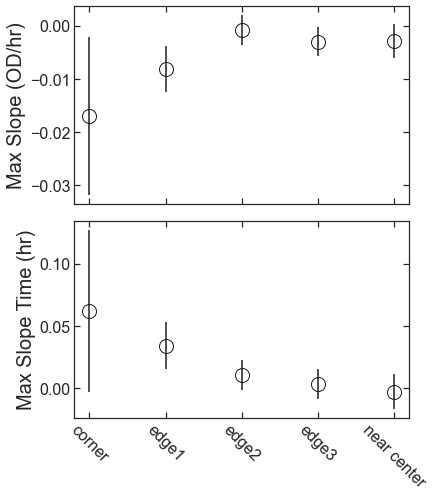

In [25]:
plt.rcParams["figure.figsize"] = [6, 8]
fig, axs = plt.subplots(2, 1)

for ax, df, y_lab in zip(axs, [max_slope_frame, max_slope_time_frame], ['Max Slope (OD/hr)', 'Max Slope Time (hr)']):
    df = df[['well_category' in s for s in df.index]]
    x_lab = [s[s.find('[T.')+3: s.rfind(']')] for s in df.index]
    x_arr = np.array([i for i in range(len(x_lab))])
    y_arr = df['mean']
    y_err = [df['mean']-df.q_025, df.q_975-df['mean']]
    ax.errorbar(x_arr, y_arr, y_err, fmt='o', color='k', ms=14, fillstyle='none');
    ax.set_ylabel(y_lab)
axs[0].set_xticklabels([]);
axs[1].set_xticks(x_arr);
x_lab = [s.replace('_', ' ') for s in x_lab]
axs[1].set_xticklabels(x_lab, rotation=-45);

shift = 0.04
box = axs[1].get_position()
box.y0 = box.y0 + shift
box.y1 = box.y1 + shift
axs[1].set_position(box)

fig.savefig("Fig. S2.png", bbox_inches="tight")

Figure S3 shows the IPTG effects:

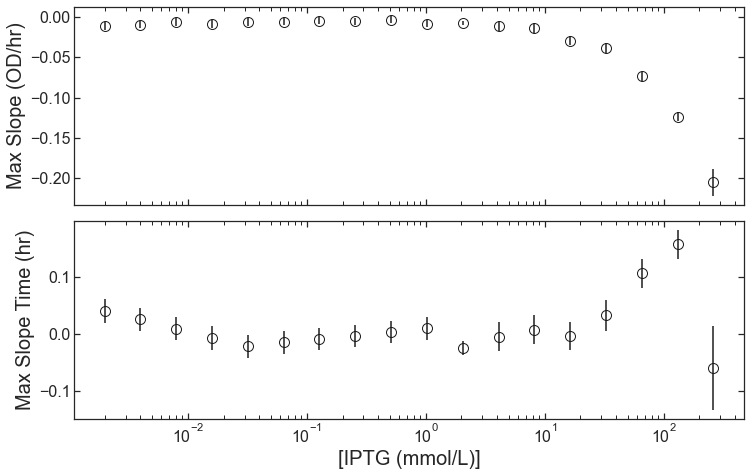

In [26]:
plt.rcParams["figure.figsize"] = [12, 8]
fig, axs = plt.subplots(2, 1)

for ax, df, y_lab in zip(axs, [max_slope_frame, max_slope_time_frame], ['Max Slope (OD/hr)', 'Max Slope Time (hr)']):
    df = df[['IPTG' in s for s in df.index]]
    x = [float(s[s.find('[T.')+3: s.rfind(']')]) for s in df.index]
    y = df['mean'] #/factor
    yerr = np.array([df['mean']-df.q_025, df.q_975-df['mean']]) #/factor
    ax.errorbar(x, y, yerr, fmt='o', color='k', ms=10, fillstyle='none');
    ax.set_xscale('log')
    ax.set_ylabel(y_lab)
axs[1].set_xlabel('[IPTG (mmol/L)]');
axs[0].set_xticklabels([]);

shift = 0.04
box = axs[1].get_position()
box.y0 = box.y0 + shift
box.y1 = box.y1 + shift
axs[1].set_position(box)

fig.savefig("Fig. S3.png", bbox_inches="tight")

In [27]:
# What is pre_post_covid effect?:

for df in [max_slope_frame, max_slope_time_frame]:
    df = df[['pre_post_covid' in s for s in df.index]]
    display(df)

,q_025,q_975,mean,q_25,q_75,p_value
C(pre_post_covid)[T.B],-0.041657,-0.018533,-0.030095,-0.034074,-0.026116,3.366677e-07


,q_025,q_975,mean,q_25,q_75,p_value
C(pre_post_covid)[T.B],0.139557,0.274754,0.207156,0.183893,0.230418,1.897637e-09


Look at rondom effects as estimates of reproducibility:

In [28]:
rand_effects_slope = np.array([x.iloc[0] for x in max_slope_model.random_effects.values()])
rand_effects_time = np.array([x.iloc[0] for x in max_slope_time_model.random_effects.values()])

In [29]:
np.std(rand_effects_slope), np.std(rand_effects_time)

(0.033082379739861396, 0.19437360548943608)

In [30]:
np.std(rand_effects_slope)/np.mean(data.max_slope.mean()), np.std(rand_effects_time)*60

(0.10417353666314781, 11.662416329366165)

Plot histograms of random effects:

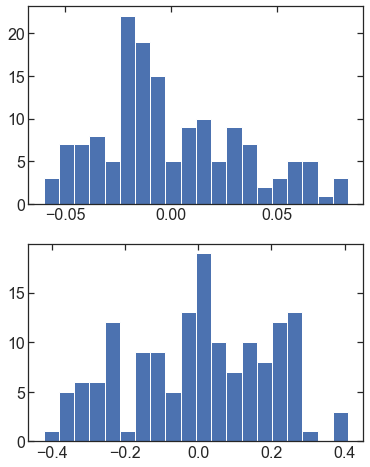

In [31]:
plt.rcParams["figure.figsize"] = [6, 8]
fig, axs = plt.subplots(2, 1)

for ax, x in zip(axs, [rand_effects_slope, rand_effects_time]):
    ax.hist(x, bins=20);

Redo the analysis with just plates from recent measurements in August, September 2021:

In [32]:
df = data[data.year=='2021']
x = np.array([int(s[s.find('-')+1:]) for s in df.month])
recent_data = df[x>6]
len(np.unique(recent_data.plate_id))

18

In [33]:
model_terms_recent = 'C(well_category) + plate_1_0 + plate_1_f'

In [34]:
md_slope = smf.mixedlm(
    f"max_slope ~ {model_terms_recent}",
    recent_data,
    groups=recent_data["plate_id"],
)
max_slope_model = md_slope.fit(method=["lbfgs"])

C:\Users\djross\Miniconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


In [35]:
max_slope_model.summary()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                  Mixed Linear Model Regression Results
==========================================================================
Model:                   MixedLM       Dependent Variable:       max_slope
No. Observations:        1296          Method:                   REML     
No. Groups:              18            Scale:                    0.0004   
Min. group size:         72            Log-Likelihood:           3142.5254
Max. group size:         72            Converged:                Yes      
Mean group size:         72.0                                             
--------------------------------------------------------------------------
                                Coef.  Std.Err.   z    P>|z| [0.025 0.975]
--------------------------------------------------------------------------
Intercept                       -0.076    0.049 -1.557 0.119 -0.171  0.020
C(well_category)[T.edge1]       -0.006    0.003 -2.150 0.032 -0.012 -0.001
C(well_category)[T.edge2]        0.002    0.003  0.851 0.395 -0.003  0.007
C(well_category)[T.edge3]        0.000    0.003  0.133 0.894 -0.005  0.006
C(well_category)[T.near_center] -0.002    0.003 -0.664 0.507 -0.008  0.004
plate_1_0                       -0.023    0.012 -1.832 0.067 -0.047  0.002
plate_1_f                        0.141    0.019  7.568 0.000  0.104  0.177
Group Var                        0.000    0.007                           
==========================================================================

"""

In [36]:
md_time = smf.mixedlm(
    f"max_slope_time ~ {model_terms_recent}",
    recent_data,
    groups=recent_data["plate_id"],
)
max_slope_time_model = md_time.fit(method=["lbfgs"])

In [37]:
max_slope_time_model.summary()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                  Mixed Linear Model Regression Results
==========================================================================
Model:                  MixedLM     Dependent Variable:     max_slope_time
No. Observations:       1296        Method:                 REML          
No. Groups:             18          Scale:                  0.0071        
Min. group size:        72          Log-Likelihood:         1304.1004     
Max. group size:        72          Converged:              Yes           
Mean group size:        72.0                                              
--------------------------------------------------------------------------
                                Coef.  Std.Err.   z    P>|z| [0.025 0.975]
--------------------------------------------------------------------------
Intercept                        3.179    0.204 15.578 0.000  2.779  3.579
C(well_category)[T.edge1]        0.073    0.012  6.276 0.000  0.050  0.096
C(well_category)[T.edge2]        0.058    0.011  5.382 0.000  0.037  0.079
C(well_category)[T.edge3]        0.027    0.011  2.481 0.013  0.006  0.048
C(well_category)[T.near_center]  0.010    0.012  0.831 0.406 -0.014  0.034
plate_1_0                       -0.116    0.051 -2.263 0.024 -0.216 -0.016
plate_1_f                       -0.265    0.077 -3.429 0.001 -0.416 -0.113
Group Var                        0.020    0.081                           
==========================================================================

"""

In [38]:
max_slope_time_frame = max_slope_time_model.conf_int().copy()
max_slope_time_frame.rename(columns={0:'q_025', 1:'q_975'}, inplace=True)
max_slope_time_frame['mean'] = max_slope_time_model.fe_params
df = max_slope_time_model.conf_int(alpha=0.5)
max_slope_time_frame['q_25'] = df[0]
max_slope_time_frame['q_75'] = df[1]
#max_slope_time_frame

In [39]:
max_slope_frame = max_slope_model.conf_int().copy()
max_slope_frame.rename(columns={0:'q_025', 1:'q_975'}, inplace=True)
max_slope_frame['mean'] = max_slope_model.fe_params
df = max_slope_model.conf_int(alpha=0.5)
max_slope_frame['q_25'] = df[0]
max_slope_frame['q_75'] = df[1]
#max_slope_frame

Figure S4 shows well position effects for the recent data:

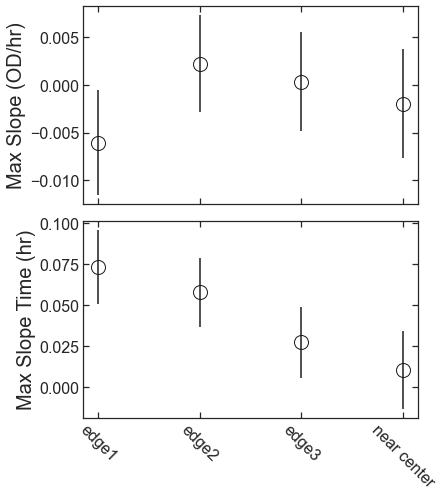

In [40]:
plt.rcParams["figure.figsize"] = [6, 8]
fig, axs = plt.subplots(2, 1)

for ax, df, y_lab in zip(axs, [max_slope_frame, max_slope_time_frame], ['Max Slope (OD/hr)', 'Max Slope Time (hr)']):
    df = df[['well_category' in s for s in df.index]]
    x_lab = [s[s.find('[T.')+3: s.rfind(']')] for s in df.index]
    x_arr = np.array([i for i in range(len(x_lab))])
    y_arr = df['mean']
    y_err = [df['mean']-df.q_025, df.q_975-df['mean']]
    ax.errorbar(x_arr, y_arr, y_err, fmt='o', color='k', ms=14, fillstyle='none');
    ax.set_ylabel(y_lab)
axs[0].set_xticklabels([]);
axs[1].set_xticks(x_arr);
x_lab = [s.replace('_', ' ') for s in x_lab]
axs[1].set_xticklabels(x_lab, rotation=-45);

shift = 0.04
box = axs[1].get_position()
box.y0 = box.y0 + shift
box.y1 = box.y1 + shift
axs[1].set_position(box)

fig.savefig("Fig. S4.png", bbox_inches="tight")

Random effects for model with recent dataset:

In [41]:
rand_effects_slope = np.array([x.iloc[0] for x in max_slope_model.random_effects.values()])
rand_effects_time = np.array([x.iloc[0] for x in max_slope_time_model.random_effects.values()])

In [42]:
np.std(rand_effects_slope), np.std(rand_effects_time)

(0.019808656564075044, 0.13571385389505072)

In [43]:
np.std(rand_effects_slope)/np.mean(recent_data.max_slope), 60*np.std(rand_effects_time)

(0.0578547232572116, 8.142831233703044)

Plot histograms of random effects:

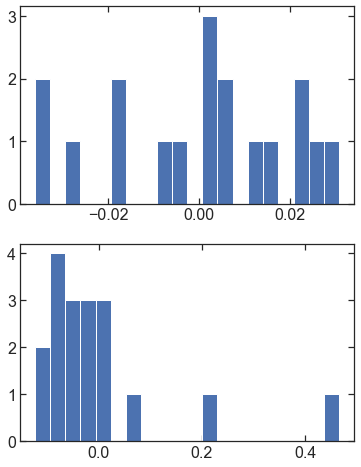

In [44]:
plt.rcParams["figure.figsize"] = [6, 8]
fig, axs = plt.subplots(2, 1)

for ax, x in zip(axs, [rand_effects_slope, rand_effects_time]):
    ax.hist(x, bins=20);

Re-analyze with radom sub-samples and look at p-values analysis with recent data:

In [45]:
recent_len = len(np.unique(recent_data.plate_id))
recent_len

18

In [46]:
num_samples = [1, 2, 3, 4, 6, 8, 10, 12, 16]
num_samples

[1, 2, 3, 4, 6, 8, 10, 12, 16]

In [47]:
recent_plates = np.unique(recent_data.plate_id)

In [48]:
%%time
n_list = []
slope_p_list = []
time_p_list = []

rng = np.random.default_rng(seed=1)

with warnings.catch_warnings():
    warnings.filterwarnings("ignore")
    for n in num_samples:
        for i in range(10):
            n_list.append(n)
            
            plate_list = rng.choice(recent_plates, n, replace=False)
            
            df = recent_data[[x in plate_list for x in recent_data.plate_id]]
            #display(df)

            md = smf.mixedlm(
                f"max_slope ~ {model_terms_recent}",
                df,
                groups=df["plate_id"],
            )
            fit = md.fit(method=["lbfgs"])
            slope_p = fit.pvalues.loc['C(well_category)[T.edge1]']
            slope_p_list.append(slope_p)

            md = smf.mixedlm(
                f"max_slope_time ~ {model_terms_recent}",
                df,
                groups=df["plate_id"],
            )
            fit = md.fit(method=["lbfgs"])
            time_p = fit.pvalues.loc['C(well_category)[T.edge1]']
            time_p_list.append(time_p)
            
df = recent_data
n_list.append(len(recent_plates))
md = smf.mixedlm(
    f"max_slope ~ {model_terms_recent}",
    df,
    groups=df["plate_id"],
)
fit = md.fit(method=["lbfgs"])
fit_recent_slope = fit
slope_p = fit.pvalues.loc['C(well_category)[T.edge1]']
slope_p_list.append(slope_p)

md = smf.mixedlm(
    f"max_slope_time ~ {model_terms_recent}",
    df,
    groups=df["plate_id"],
)
fit = md.fit(method=["lbfgs"])
fit_recent_time = fit
time_p = fit.pvalues.loc['C(well_category)[T.edge1]']
time_p_list.append(time_p)

Wall time: 3.79 s


C:\Users\djross\Miniconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


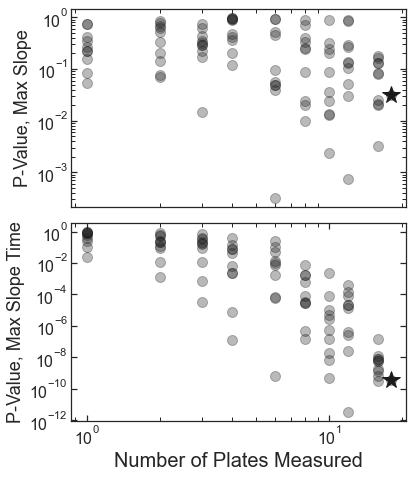

In [49]:
plt.rcParams["figure.figsize"] = [6, 8]
fig, axs = plt.subplots(2, 1)
#fig.suptitle('p-values for edge1 category', size=20, y=0.93)

x = n_list
for ax, y, y_lab in zip(axs, [slope_p_list, time_p_list], ['P-Value, Max Slope', 'P-Value, Max Slope Time']):
    ax.plot(x, y, 'o', ms=10, alpha=0.3, color='k');
    ax.plot(x[-1], y[-1], '*', ms=18, alpha=1, color='k');
    ax.set_yscale('log');
    ax.set_xscale('log');
    ylim = ax.get_ylim()
    #ax.set_ylim(y[-1]/2, 2);
    ax.set_ylabel(y_lab, size=18);
axs[1].set_xlabel('Number of Plates Measured');
axs[1].set_yticks([10**(-x) for x in range(0, 13, 2)])
axs[0].set_xticks([])

shift = 0.04
box = axs[1].get_position()
box.y0 = box.y0 + shift
box.y1 = box.y1 + shift
axs[1].set_position(box)

fig.savefig("Fig. S5.png", bbox_inches="tight")

Look at median p-value as a function of n:

In [50]:
n_list = np.array(n_list)
time_p_list = np.array(time_p_list)
for x in np.unique(n_list):
    y = time_p_list[n_list==x].copy()
    y_median = np.median(y)
    print(f'{x}: {y_median}')

1: 0.6696793466856221
2: 0.2135688144310886
3: 0.17751703244876194
4: 0.02498113998309496
6: 0.009050982297048323
8: 5.5015194256312805e-05
10: 1.596589866785235e-06
12: 1.761247089034664e-05
16: 6.1891692715547686e-09
18: 3.4791042719481376e-10


In [51]:
%%time
n_list = []
slope_p2_list = []
time_p2_list = []

rng = np.random.default_rng(seed=1)

with warnings.catch_warnings():
    warnings.filterwarnings("ignore")
    for n in num_samples:
        for i in range(10):
            n_list.append(n)
            
            plate_list = rng.choice(recent_plates, n, replace=False)
            
            df = recent_data[[x in plate_list for x in recent_data.plate_id]]
            #display(df)

            md = smf.mixedlm(
                f"max_slope ~ {model_terms_recent}",
                df,
                groups=df["plate_id"],
            )
            fit = md.fit(method=["lbfgs"])
            slope_p = fit.pvalues.loc['C(well_category)[T.edge2]']
            slope_p2_list.append(slope_p)

            md = smf.mixedlm(
                f"max_slope_time ~ {model_terms_recent}",
                df,
                groups=df["plate_id"],
            )
            fit = md.fit(method=["lbfgs"])
            time_p = fit.pvalues.loc['C(well_category)[T.edge2]']
            time_p2_list.append(time_p)
            
df = recent_data
n_list.append(len(recent_plates))
md = smf.mixedlm(
    f"max_slope ~ {model_terms_recent}",
    df,
    groups=df["plate_id"],
)
fit = md.fit(method=["lbfgs"])
slope_p = fit.pvalues.loc['C(well_category)[T.edge2]']
slope_p2_list.append(slope_p)

md = smf.mixedlm(
    f"max_slope_time ~ {model_terms_recent}",
    df,
    groups=df["plate_id"],
)
fit = md.fit(method=["lbfgs"])
time_p = fit.pvalues.loc['C(well_category)[T.edge2]']
time_p2_list.append(time_p)

Wall time: 4 s


C:\Users\djross\Miniconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


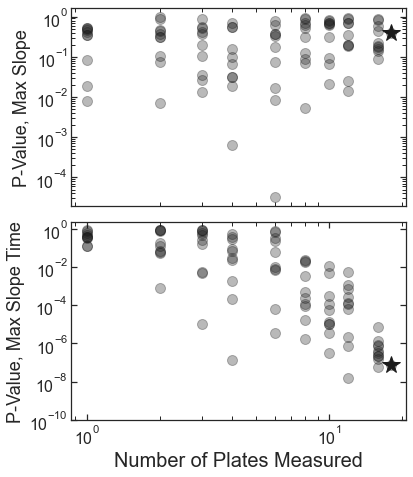

In [52]:
plt.rcParams["figure.figsize"] = [6, 8]
fig, axs = plt.subplots(2, 1)

x = n_list
for ax, y, y_lab in zip(axs, [slope_p2_list, time_p2_list], ['P-Value, Max Slope', 'P-Value, Max Slope Time']):
    ax.plot(x, y, 'o', ms=10, alpha=0.3, color='k');
    ax.plot(x[-1], y[-1], '*', ms=18, alpha=1, color='k');
    ax.set_yscale('log');
    ax.set_xscale('log');
    ylim = ax.get_ylim()
    #ax.set_ylim(y[-1]/2, 2);
    ax.set_ylabel(y_lab, size=18);
axs[1].set_xlabel('Number of Plates Measured');
axs[1].set_yticks([10**(-x) for x in range(0, 11, 2)])
axs[0].set_xticks([])

shift = 0.04
box = axs[1].get_position()
box.y0 = box.y0 + shift
box.y1 = box.y1 + shift
axs[1].set_position(box)

fig.savefig("Fig. S6.png", bbox_inches="tight")

Look at median p-value as a function of n:

In [53]:
n_list = np.array(n_list)
time_p2_list = np.array(time_p2_list)
for x in np.unique(n_list):
    y = time_p2_list[n_list==x].copy()
    y_median = np.median(y)
    print(f'{x}: {y_median}')

1: 0.3932022382233793
2: 0.15722657132284013
3: 0.3734344389255129
4: 0.049574601332169184
6: 0.03732624556566856
8: 0.0003628186430809279
10: 3.470336670358469e-05
12: 0.0001306762991199767
16: 3.752801646814883e-07
18: 7.375332835183078e-08


Check recent data with IPTG as fixed effect:

In [54]:
model_terms_iptg = 'C(IPTG) + plate_1_0 + plate_1_f'

In [55]:
md_slope = smf.mixedlm(
    f"max_slope ~ {model_terms_iptg}",
    recent_data,
    groups=recent_data["plate_id"],
)
max_slope_model = md_slope.fit(method=["lbfgs"])

C:\Users\djross\Miniconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


In [56]:
max_slope_model.summary()

<class 'statsmodels.iolib.summary2.Summary'>
"""
           Mixed Linear Model Regression Results
===========================================================
Model:              MixedLM  Dependent Variable:  max_slope
No. Observations:   1296     Method:              REML     
No. Groups:         18       Scale:               0.0004   
Min. group size:    72       Log-Likelihood:      3140.7998
Max. group size:    72       Converged:           Yes      
Mean group size:    72.0                                   
-----------------------------------------------------------
                 Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-----------------------------------------------------------
Intercept         0.025    0.052  0.481 0.631 -0.077  0.128
C(IPTG)[T.0.002] -0.006    0.003 -2.270 0.023 -0.011 -0.001
C(IPTG)[T.0.004] -0.004    0.003 -1.385 0.166 -0.009  0.002
C(IPTG)[T.0.008]  0.002    0.003  0.702 0.483 -0.003  0.007
C(IPTG)[T.0.016] -0.002    0.003 -0.718 0.473 -0.007  0.003
C(IPTG)[T.0.032] -0.003    0.003 -0.953 0.341 -0.008  0.003
C(IPTG)[T.0.064]  0.003    0.003  1.003 0.316 -0.003  0.008
C(IPTG)[T.0.128]  0.004    0.003  1.487 0.137 -0.001  0.009
C(IPTG)[T.0.256]  0.004    0.003  1.399 0.162 -0.002  0.009
C(IPTG)[T.0.512] -0.000    0.003 -0.112 0.911 -0.006  0.005
C(IPTG)[T.1.024] -0.007    0.003 -2.644 0.008 -0.013 -0.002
C(IPTG)[T.2.048] -0.017    0.003 -5.995 0.000 -0.022 -0.011
plate_1_0         0.007    0.013  0.538 0.590 -0.018  0.032
plate_1_f         0.092    0.020  4.566 0.000  0.052  0.131
Group Var         0.000    0.007                           
===========================================================

"""

In [57]:
md_time = smf.mixedlm(
    f"max_slope_time ~ {model_terms_iptg}",
    recent_data,
    groups=recent_data["plate_id"],
)
max_slope_time_model = md_time.fit(method=["lbfgs"])

In [58]:
max_slope_time_model.summary()

<class 'statsmodels.iolib.summary2.Summary'>
"""
           Mixed Linear Model Regression Results
============================================================
Model:            MixedLM Dependent Variable: max_slope_time
No. Observations: 1296    Method:             REML          
No. Groups:       18      Scale:              0.0065        
Min. group size:  72      Log-Likelihood:     1338.4625     
Max. group size:  72      Converged:          Yes           
Mean group size:  72.0                                      
------------------------------------------------------------
                  Coef.  Std.Err.   z    P>|z| [0.025 0.975]
------------------------------------------------------------
Intercept          2.948    0.215 13.706 0.000  2.526  3.369
C(IPTG)[T.0.002]  -0.001    0.011 -0.122 0.903 -0.023  0.020
C(IPTG)[T.0.004]  -0.016    0.011 -1.488 0.137 -0.038  0.005
C(IPTG)[T.0.008]  -0.051    0.011 -4.652 0.000 -0.073 -0.030
C(IPTG)[T.0.016]  -0.090    0.011 -8.138 0.000 -0.111 -0.068
C(IPTG)[T.0.032]  -0.082    0.011 -7.394 0.000 -0.103 -0.060
C(IPTG)[T.0.064]  -0.083    0.011 -7.523 0.000 -0.105 -0.061
C(IPTG)[T.0.128]  -0.062    0.011 -5.646 0.000 -0.084 -0.041
C(IPTG)[T.0.256]  -0.052    0.011 -4.641 0.000 -0.074 -0.030
C(IPTG)[T.0.512]  -0.010    0.011 -0.877 0.380 -0.032  0.012
C(IPTG)[T.1.024]   0.016    0.011  1.358 0.174 -0.007  0.038
C(IPTG)[T.2.048]  -0.010    0.011 -0.868 0.386 -0.032  0.012
plate_1_0         -0.248    0.052 -4.803 0.000 -0.349 -0.147
plate_1_f         -0.086    0.082 -1.051 0.293 -0.247  0.075
Group Var          0.020    0.085                           
============================================================

"""

In [59]:
max_slope_time_frame = max_slope_time_model.conf_int().copy()
max_slope_time_frame.rename(columns={0:'q_025', 1:'q_975'}, inplace=True)
max_slope_time_frame['mean'] = max_slope_time_model.fe_params
df = max_slope_time_model.conf_int(alpha=0.5)
max_slope_time_frame['q_25'] = df[0]
max_slope_time_frame['q_75'] = df[1]
#max_slope_time_frame

In [60]:
max_slope_frame = max_slope_model.conf_int().copy()
max_slope_frame.rename(columns={0:'q_025', 1:'q_975'}, inplace=True)
max_slope_frame['mean'] = max_slope_model.fe_params
df = max_slope_model.conf_int(alpha=0.5)
max_slope_frame['q_25'] = df[0]
max_slope_frame['q_75'] = df[1]
#max_slope_frame

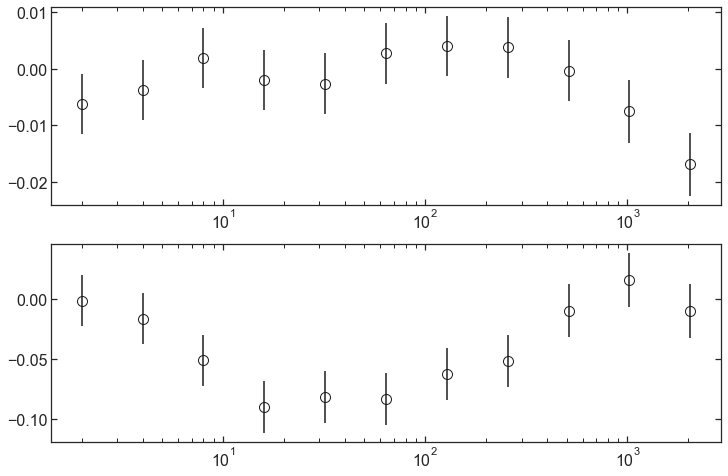

In [61]:
plt.rcParams["figure.figsize"] = [12, 8]
fig, axs = plt.subplots(2, 1)

for ax, df, factor in zip(axs, [max_slope_frame, max_slope_time_frame], [recent_data.max_slope.mean(), recent_data.max_slope_time.mean()]):
    df = df[['IPTG' in s for s in df.index]]
    x = [1000*float(s[s.find('[T.')+3: s.rfind(']')]) for s in df.index]
    y = df['mean'] #/factor
    yerr = np.array([df['mean']-df.q_025, df.q_975-df['mean']]) #/factor
    ax.errorbar(x, y, yerr, fmt='o', color='k', ms=10, fillstyle='none');
    ax.set_xscale('log')

Since effects of IPTG look ~symetric (right to left), it's probably from well_category instead.